## Nuclei Cell Image Segmentation

In [1]:
# Import packages

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, losses, optimizers, callbacks
from tensorflow_examples.models.pix2pix import pix2pix
import tensorflow_io as tfio
from IPython.display import clear_output
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os, cv2, glob
from tqdm import tqdm 
from skimage.io import imread, imshow
from skimage.transform import resize
from scipy import io

C:\Users\User\anaconda3\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\User\anaconda3\lib\site-packages\numpy\.libs\libopenblas.EL2C6PLE4ZYW3ECEVIV3OXXGRN2NRFM2.gfortran-win_amd64.dll
C:\Users\User\anaconda3\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [2]:
# Load dataset
SEED = 12345
IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_CHANNELS = 3

train_root = r"C:\Users\User\Desktop\Training\GitHub_Project\Nuclei_Image_Segmentation\data-science-bowl-2018-2\train"
test_root = r"C:\Users\User\Desktop\Training\GitHub_Project\Nuclei_Image_Segmentation\data-science-bowl-2018-2\test"
exts = ('jpg', 'JPG', 'png', 'PNG')

In [3]:
# Train dataset
train_input_data = os.path.join(train_root, 'inputs')
train_images = sorted(
    [
        os.path.join(train_input_data, fname)
        for fname in os.listdir(train_input_data)
        if fname.endswith(exts) and not fname.startswith(".")
    ]
)


train_target_data = os.path.join(train_root, 'masks')
train_masks = sorted(
    [
        os.path.join(train_target_data, fname)
        for fname in os.listdir(train_target_data)
        if fname.endswith(exts) and not fname.startswith(".")
    ]
)

print("Number of samples:", len(train_images), len(train_masks))
for input_path, target_path in zip(train_images[:10], train_masks[:10]):
    print(input_path[-32:], "|", target_path[-31:], '|', np.unique(cv2.imread(target_path)))

Number of samples: 603 603
51b21934585648c740d2c3d86dc1.png | 1b21934585648c740d2c3d86dc1.png | [  0 255]
483bf6b0740d00530220832c6d3e.png | 83bf6b0740d00530220832c6d3e.png | [  0 255]
663ec885c663859948c154a443ed.png | 63ec885c663859948c154a443ed.png | [  0 255]
5d0e2695b149b7cc0c9592b21baf.png | d0e2695b149b7cc0c9592b21baf.png | [  0 255]
309ff610dc5845e60455b0f87c21.png | 09ff610dc5845e60455b0f87c21.png | [  0 255]
6bc6127ecb7f3dd043e04ce37426.png | bc6127ecb7f3dd043e04ce37426.png | [  0 255]
54af41dd85e5a3fe3e1b6d6f9339.png | 4af41dd85e5a3fe3e1b6d6f9339.png | [  0 255]
e4d9d10f1b5fe8df8fac12380776.png | 4d9d10f1b5fe8df8fac12380776.png | [  0 255]
f36ea93b203f2c8fa58ed1dffcbe.png | 36ea93b203f2c8fa58ed1dffcbe.png | [  0 255]
33c4337ad8877aa18b1dfb59fc9a.png | 3c4337ad8877aa18b1dfb59fc9a.png | [  0 255]


In [4]:
def train_read_image(image_path, mask=False):
    train_image = tf.io.read_file(image_path)
    
    if mask:
        train_image = tf.image.decode_png(train_image, channels=1)
        train_image.set_shape([None, None, 1])
        train_image = tf.image.resize(images=train_image, size=[IMAGE_SIZE, IMAGE_SIZE])
        train_image = tf.cast(train_image, tf.int32)
    else:
        train_image = tf.image.decode_png(train_image, channels=3)
        train_image.set_shape([None, None, 3])
        train_image = tf.image.resize(images=train_image, size=[IMAGE_SIZE, IMAGE_SIZE])
        train_image = train_image / 255.
        
    return train_image

def train_load_data(image_list, mask_list):
    image = train_read_image(image_list)
    mask  = train_read_image(mask_list, mask=True)
    return image, mask

def train_data_generator(image_list, mask_list, split='train'):
    dataset = tf.data.Dataset.from_tensor_slices((image_list, mask_list))
    dataset = dataset.shuffle(8*BATCH_SIZE) if split == 'train' else dataset 
    dataset = dataset.map(train_load_data, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)
    return dataset

IMAGE_SIZE = 128
BATCH_SIZE = 32

train_dataset = train_data_generator(train_images, train_masks)
print("Train Dataset:", train_dataset)

Train Dataset: <PrefetchDataset element_spec=(TensorSpec(shape=(32, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(32, 128, 128, 1), dtype=tf.int32, name=None))>


In [5]:
#Test dataset
test_input_data = os.path.join(test_root, 'inputs')
test_images = sorted(
    [
        os.path.join(test_input_data, fname)
        for fname in os.listdir(test_input_data)
        if fname.endswith(exts) and not fname.startswith(".")
    ]
)


test_target_data = os.path.join(test_root, 'masks')
test_masks = sorted(
    [
        os.path.join(test_target_data, fname)
        for fname in os.listdir(test_target_data)
        if fname.endswith(exts) and not fname.startswith(".")
    ]
)

print("Number of samples:", len(test_images), len(test_masks))
for input_path, target_path in zip(test_masks[:10], test_masks[:10]):
    print(input_path[-32:], "|", target_path[-31:], '|', np.unique(cv2.imread(target_path)))

Number of samples: 67 67
0c92466da21d4a04cd5413362552.png | c92466da21d4a04cd5413362552.png | [  0 255]
a3d269358717295bab1504c7c275.png | 3d269358717295bab1504c7c275.png | [  0 255]
758d224de4608f9b960106d4f9ca.png | 58d224de4608f9b960106d4f9ca.png | [  0 255]
c45d845b4124ffea380c92d34c8c.png | 45d845b4124ffea380c92d34c8c.png | [  0 255]
09f7201cf2b70b111fc3b853d14f.png | 9f7201cf2b70b111fc3b853d14f.png | [  0 255]
c3940df1d28cfc7fd817c83714e1.png | 3940df1d28cfc7fd817c83714e1.png | [  0 255]
c114ce4cacd8b540648892945b00.png | 114ce4cacd8b540648892945b00.png | [  0 255]
c0cd088eb5bc3382f8df9355443d.png | 0cd088eb5bc3382f8df9355443d.png | [  0 255]
b6c1b01896246048e83c345c0914.png | 6c1b01896246048e83c345c0914.png | [  0 255]
37ef3e7c767a8c45c9ac733b91bf.png | 7ef3e7c767a8c45c9ac733b91bf.png | [  0 255]


In [6]:
# Test
def test_read_image(image_path, mask=False):
    test_image = tf.io.read_file(image_path)
    
    if mask:
        test_image = tf.image.decode_png(test_image, channels=1)
        test_image.set_shape([None, None, 1])
        test_image = tf.image.resize(images=test_image, size=[IMAGE_SIZE, IMAGE_SIZE])
        test_image = tf.cast(test_image, tf.int32)
    else:
        test_image = tf.image.decode_png(test_image, channels=3)
        test_image.set_shape([None, None, 3])
        test_image = tf.image.resize(images=test_image, size=[IMAGE_SIZE, IMAGE_SIZE])
        test_image = test_image / 255.
        
    return test_image

def test_load_data(image_list, mask_list):
    test_image = test_read_image(image_list)
    test_mask  = test_read_image(mask_list, mask=True)
    return test_image, test_mask

def test_data_generator(image_list, mask_list, split='test'):
    dataset = tf.data.Dataset.from_tensor_slices((image_list, mask_list))
    dataset = dataset.shuffle(8*BATCH_SIZE) if split == 'test' else dataset 
    dataset = dataset.map(test_load_data, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)
    return dataset

IMAGE_SIZE = 128
BATCH_SIZE = 32

test_dataset = test_data_generator(test_images, test_masks)
print("Test Dataset:", test_dataset)

Test Dataset: <PrefetchDataset element_spec=(TensorSpec(shape=(32, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(32, 128, 128, 1), dtype=tf.int32, name=None))>


In [7]:
# Train images display

import matplotlib.pyplot as plt 

def visualize(**train_images):
    """PLot images in one row."""
    n = len(train_images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(train_images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()
    


(32, 128, 128, 3) (32, 128, 128, 1)
0 255


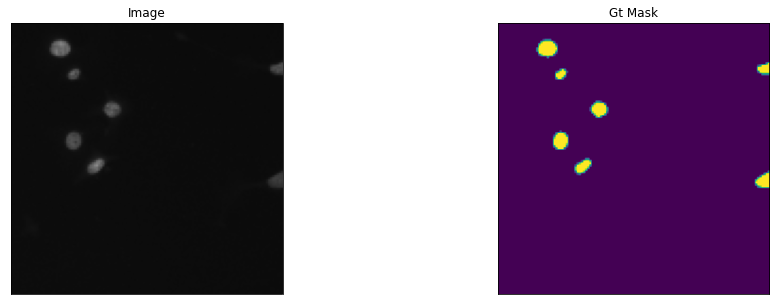

0 255


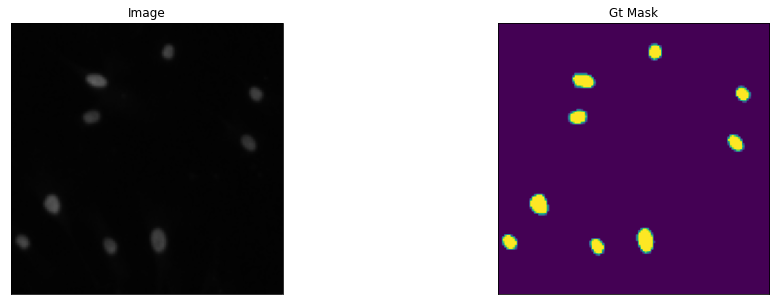

0 255


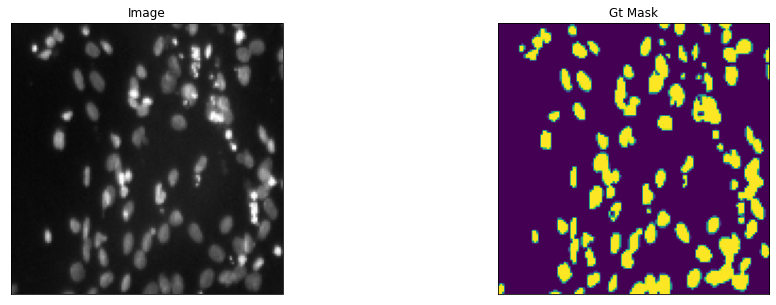

0 255


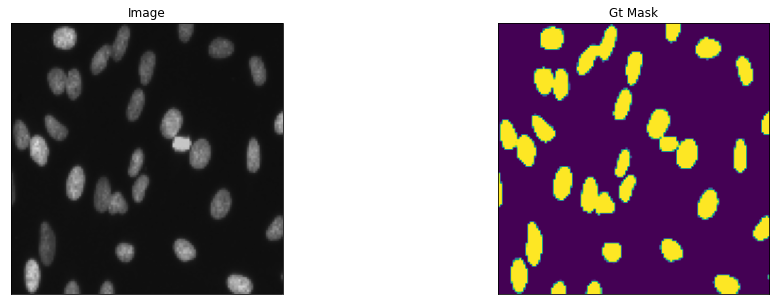

0 255


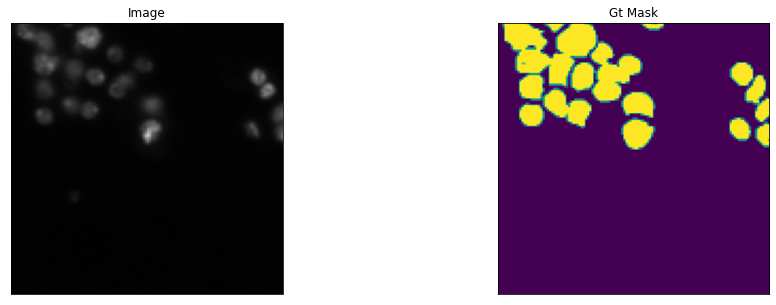

In [8]:
train_images, train_masks = next(iter(train_dataset.take(1))) # train_dataset
print(train_images.shape, train_masks.shape)

for (img, msk) in zip(train_images[:5], train_masks[:5]):
    print(train_masks.numpy().min(), train_masks.numpy().max())
    visualize(
        image=img.numpy(),
        gt_mask=msk.numpy(), 
    )

In [9]:
#  Test images display
import matplotlib.pyplot as plt 

def visualize(**test_images):
    """PLot images in one row."""
    n = len(test_images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(test_images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()
    


(32, 128, 128, 3) (32, 128, 128, 1)
0 255


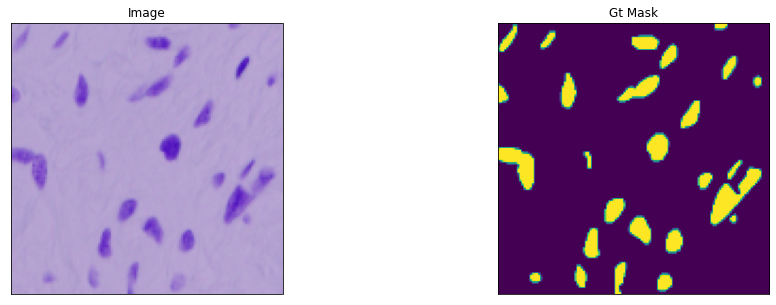

0 255


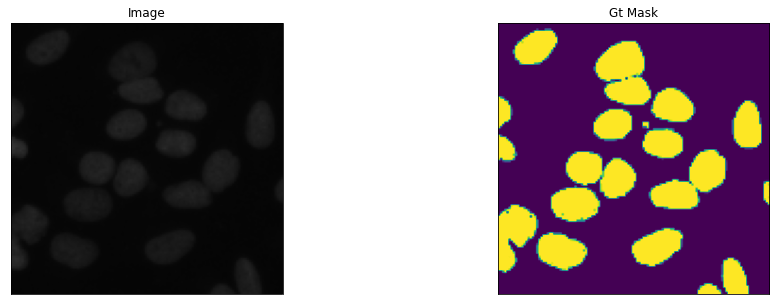

0 255


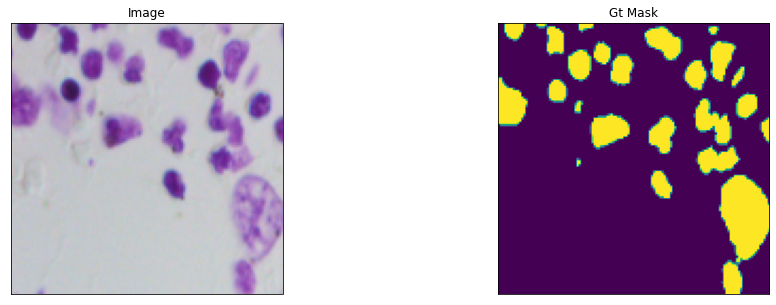

0 255


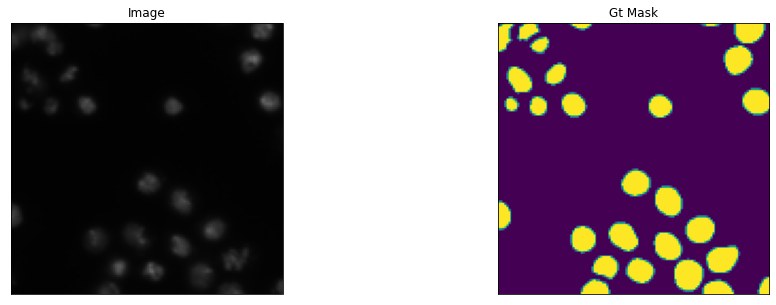

0 255


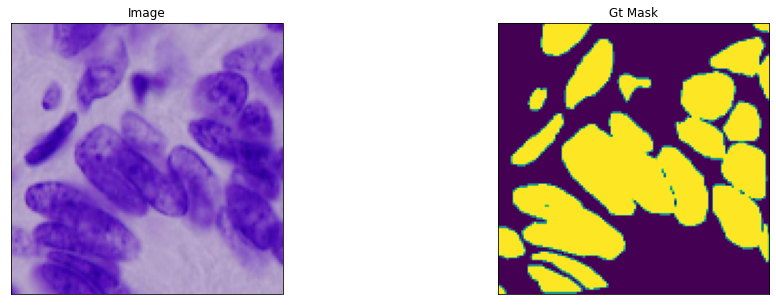

In [10]:
test_images, test_masks = next(iter(train_dataset.take(1))) # train_dataset
print(test_images.shape, test_masks.shape)

for (img, msk) in zip(test_images[:5], test_masks[:5]):
    print(test_masks.numpy().min(), test_masks.numpy().max())
    visualize(
        image=img.numpy(),
        gt_mask=msk.numpy(), 
    )

In [11]:
# U-Net model

def get_model(img_size, num_classes):
    inputs = keras.Input(shape=img_size + (3,))

    ### [First half of the network: downsampling inputs] ###

    # Entry block
    x = layers.Conv2D(32, 3, strides=2, padding="same")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    # Blocks 1, 2, 3 are identical apart from the feature depth.
    for filters in [64, 128, 256]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(filters, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    ### [Second half of the network: upsampling inputs] ###

    for filters in [256, 128, 64, 32]:
        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.UpSampling2D(2)(x)

        # Project residual
        residual = layers.UpSampling2D(2)(previous_block_activation)
        residual = layers.Conv2D(filters, 1, padding="same")(residual)
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    # Add a per-pixel classification layer
    outputs = layers.Conv2D(num_classes, 3, activation="softmax", padding="same")(x)

    # Define the model
    model = keras.Model(inputs, outputs)
    return model


# Free up RAM in case the model definition cells were run multiple times
keras.backend.clear_session()

# Build model
model = get_model(img_size=(IMAGE_SIZE, IMAGE_SIZE), num_classes=1)
keras.utils.plot_model(model, show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


In [12]:
# Compile the model
loss = losses.SparseCategoricalCrossentropy(from_logits=True)
model.compile(optimizer='adam',loss=loss,metrics=['accuracy'])
keras.utils.plot_model(model, show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


In [18]:
class DisplayCallback(tf.keras.callbacks.Callback):
    def __init__(self, dataset, epoch_interval=5):
        self.dataset = dataset
        self.epoch_interval = epoch_interval
    
    def display(self, display_list, extra_title=''):
        plt.figure(figsize=(15, 15))
        title = ['Input Image', 'True Mask', 'Predicted Mask']

        if len(display_list) > len(title):
            title.append(extra_title)

        for i in range(len(display_list)):
            plt.subplot(1, len(display_list), i+1)
            plt.title(title[i])
            plt.imshow(display_list[i])
            plt.axis('off')
        plt.show()
        
    def create_mask(self, pred_mask):
        pred_mask = (pred_mask > 0.5).astype("int32")
        return pred_mask[0]
    
    def show_predictions(self, dataset, num=1):
        for image, mask in dataset.take(num):
            pred_mask = model.predict(image)
            self.display([image[0], mask[0], self.create_mask(pred_mask)])
        
    def on_epoch_end(self, epoch, logs=None):
        if epoch and epoch % self.epoch_interval == 0:
            self.show_predictions(self.dataset)
            print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

Epoch 1/30
18/18 [==============================] - 3s 166ms/step - loss: nan - accuracy: 0.8496 - val_loss: nan - val_accuracy: 0.8336
Epoch 2/30
18/18 [==============================] - 3s 164ms/step - loss: nan - accuracy: 0.8475 - val_loss: nan - val_accuracy: 0.8305
Epoch 3/30
18/18 [==============================] - 3s 167ms/step - loss: nan - accuracy: 0.8486 - val_loss: nan - val_accuracy: 0.8304
Epoch 4/30
18/18 [==============================] - 3s 166ms/step - loss: nan - accuracy: 0.8491 - val_loss: nan - val_accuracy: 0.8338
Epoch 5/30
18/18 [==============================] - 3s 166ms/step - loss: nan - accuracy: 0.8492 - val_loss: nan - val_accuracy: 0.8323
Epoch 6/30
1/1 [==============================] - 1s 522ms/steposs: nan - accuracy: 0.84


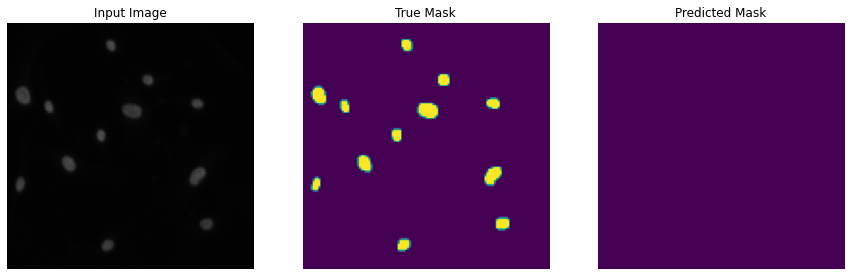


Sample Prediction after epoch 6

18/18 [==============================] - 4s 212ms/step - loss: nan - accuracy: 0.8478 - val_loss: nan - val_accuracy: 0.8358
Epoch 7/30
18/18 [==============================] - 3s 163ms/step - loss: nan - accuracy: 0.8492 - val_loss: nan - val_accuracy: 0.8337
Epoch 8/30
18/18 [==============================] - 3s 165ms/step - loss: nan - accuracy: 0.8475 - val_loss: nan - val_accuracy: 0.8318
Epoch 9/30
18/18 [==============================] - 3s 163ms/step - loss: nan - accuracy: 0.8483 - val_loss: nan - val_accuracy: 0.8383
Epoch 10/30
18/18 [==============================] - 3s 163ms/step - loss: nan - accuracy: 0.8493 - val_loss: nan - val_accuracy: 0.8345
Epoch 11/30
1/1 [==============================] - 0s 22ms/steploss: nan - accuracy: 0.84


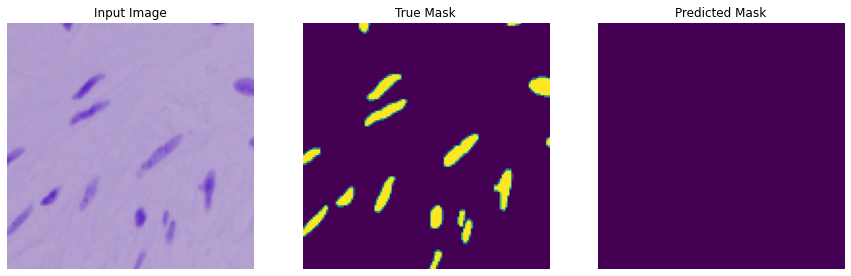


Sample Prediction after epoch 11

18/18 [==============================] - 3s 192ms/step - loss: nan - accuracy: 0.8470 - val_loss: nan - val_accuracy: 0.8290
Epoch 12/30
18/18 [==============================] - 3s 167ms/step - loss: nan - accuracy: 0.8488 - val_loss: nan - val_accuracy: 0.8314
Epoch 13/30
18/18 [==============================] - 3s 165ms/step - loss: nan - accuracy: 0.8458 - val_loss: nan - val_accuracy: 0.8287
Epoch 14/30
18/18 [==============================] - 3s 163ms/step - loss: nan - accuracy: 0.8481 - val_loss: nan - val_accuracy: 0.8299
Epoch 15/30
18/18 [==============================] - 3s 165ms/step - loss: nan - accuracy: 0.8483 - val_loss: nan - val_accuracy: 0.8333
Epoch 16/30
1/1 [==============================] - 0s 27ms/steploss: nan - accuracy: 0.84


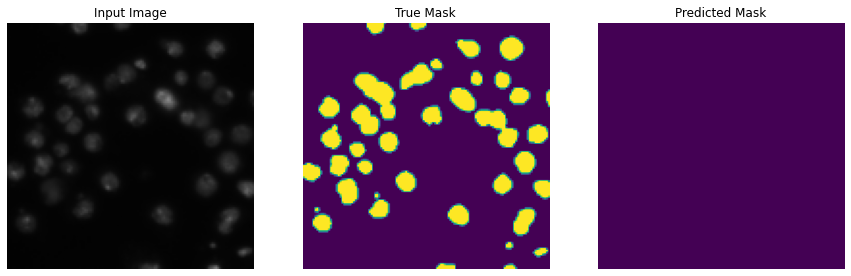


Sample Prediction after epoch 16

18/18 [==============================] - 3s 181ms/step - loss: nan - accuracy: 0.8474 - val_loss: nan - val_accuracy: 0.8433
Epoch 17/30
18/18 [==============================] - 3s 164ms/step - loss: nan - accuracy: 0.8479 - val_loss: nan - val_accuracy: 0.8326
Epoch 18/30
18/18 [==============================] - 3s 165ms/step - loss: nan - accuracy: 0.8485 - val_loss: nan - val_accuracy: 0.8332
Epoch 19/30
18/18 [==============================] - 3s 165ms/step - loss: nan - accuracy: 0.8480 - val_loss: nan - val_accuracy: 0.8294
Epoch 20/30
18/18 [==============================] - 3s 166ms/step - loss: nan - accuracy: 0.8488 - val_loss: nan - val_accuracy: 0.8297
Epoch 21/30
1/1 [==============================] - 0s 39ms/steploss: nan - accuracy: 0.84


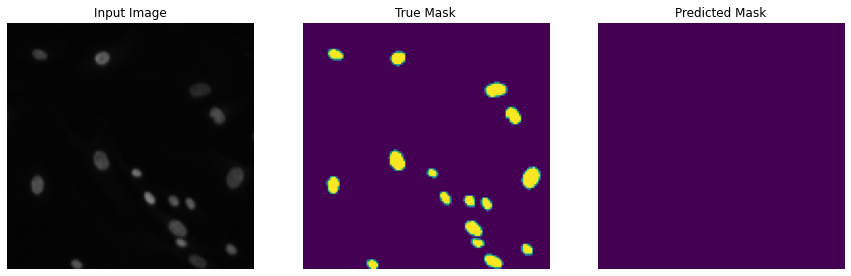


Sample Prediction after epoch 21

18/18 [==============================] - 3s 184ms/step - loss: nan - accuracy: 0.8479 - val_loss: nan - val_accuracy: 0.8362
Epoch 22/30
18/18 [==============================] - 3s 164ms/step - loss: nan - accuracy: 0.8495 - val_loss: nan - val_accuracy: 0.8428
Epoch 23/30
18/18 [==============================] - 3s 163ms/step - loss: nan - accuracy: 0.8479 - val_loss: nan - val_accuracy: 0.8367
Epoch 24/30
18/18 [==============================] - 3s 165ms/step - loss: nan - accuracy: 0.8482 - val_loss: nan - val_accuracy: 0.8296
Epoch 25/30
18/18 [==============================] - 3s 165ms/step - loss: nan - accuracy: 0.8480 - val_loss: nan - val_accuracy: 0.8321
Epoch 26/30
1/1 [==============================] - 0s 55ms/steploss: nan - accuracy: 0.84


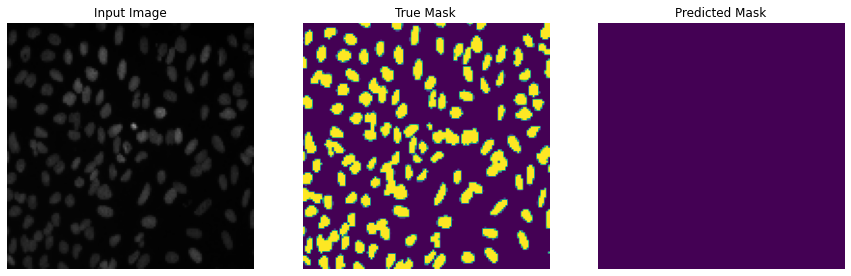


Sample Prediction after epoch 26

18/18 [==============================] - 3s 186ms/step - loss: nan - accuracy: 0.8488 - val_loss: nan - val_accuracy: 0.8360
Epoch 27/30
18/18 [==============================] - 3s 163ms/step - loss: nan - accuracy: 0.8501 - val_loss: nan - val_accuracy: 0.8353
Epoch 28/30
18/18 [==============================] - 3s 165ms/step - loss: nan - accuracy: 0.8490 - val_loss: nan - val_accuracy: 0.8299
Epoch 29/30
18/18 [==============================] - 3s 167ms/step - loss: nan - accuracy: 0.8469 - val_loss: nan - val_accuracy: 0.8334
Epoch 30/30
18/18 [==============================] - 3s 167ms/step - loss: nan - accuracy: 0.8496 - val_loss: nan - val_accuracy: 0.8302


In [19]:
# Model training
epochs = 30
model.fit(
    train_dataset, 
    epochs=epochs, 
    callbacks=[DisplayCallback(train_dataset)],
    validation_data=test_dataset,
    shuffle = True,
)